In [1]:
import os, re, sys, argparse, glob
import numpy as np
from network_topology import *
from matplotlib_helper import *
from common_util import *
from math import sqrt
import math
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.ticker import *

In [2]:
ROOT_DIR = os.path.expanduser('../data/3.fault-tolerance/failure-vs-path-length')

In [5]:
def parse_flow_path_stats_file(filename):
    path_length_by_fail_rate = {}
    regex_odd = re.compile(r'Processing file "([\d.]+)/exp(\d+)/flow-paths.txt.tm0"')
    regex_even = re.compile(r'Average hop count: ([\d.]+)')
    line_num = 1
    fail_rate = None
    for line in open(filename):
        line = line.strip()
        if line_num % 2 == 1:
            # odd lines, e.g. "Processing file "0.00/exp1/flow-paths.txt.tm0" ..."
            m = regex_odd.match(line)
            assert m, 'Cannot parse "%s"' % line
            fail_rate = float(m.group(1))
            exp_num = int(m.group(2))
        else:
            # even lines, e.g. "Average hop count: 4.54"
            # note: hop count includes all "Queue"s, thus rack-to-rack hops should be decremented by 2
            m = regex_even.match(line)
            assert m, 'Cannot parse "%s"' % line
            hop_count = float(m.group(1))
            path_length = hop_count - 2 # convert server-to-server to rack-to-rack
            if fail_rate not in path_length_by_fail_rate:
                path_length_by_fail_rate[fail_rate] = []
            path_length_by_fail_rate[fail_rate].append(path_length)
            fail_rate = None
        line_num += 1
    print('Parsed %d entries from file "%s"' % (line_num // 2, filename), file=sys.stderr)
    return path_length_by_fail_rate

Parsed 340 entries from file "../data/3.fault-tolerance/failure-vs-path-length/single/flow-paths.stats.txt"
[ Serial low-bw ]
x	: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25
y	: 2.54, 2.55, 2.55, 2.56, 2.57, 2.58, 2.58, 2.59, 2.6, 2.61, 2.62, 2.67, 2.73, 2.81
yerr	: 0.00218, 0.00433, 0.00433, 0.00497, 0.003, 0.00458, 0.00572, 0.00583, 0.00622, 0.00589, 0.00497, 0.00654, 0.0102, 0.0119
Parsed 340 entries from file "../data/3.fault-tolerance/failure-vs-path-length/homogeneous/flow-paths.stats.txt"
[ Parallel homogeneous ]
x	: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25
y	: 2.54, 2.54, 2.54, 2.54, 2.54, 2.54, 2.54, 2.54, 2.54, 2.54, 2.54, 2.54, 2.54, 2.55
yerr	: 0.00218, 0.00218, 0.00218, 0.00218, 0.00218, 0.00218, 0.00218, 0.00218, 0.00218, 0.00218, 0.00218, 0, 0.005, 0.004
Parsed 340 entries from file "../data/3.fault-tolerance/failure-vs-path-length/heterogeneous/flow-paths.stats.txt"
[ Parallel heterogeneous ]
x	: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25
y	: 1.94, 1.95, 1.95, 1.

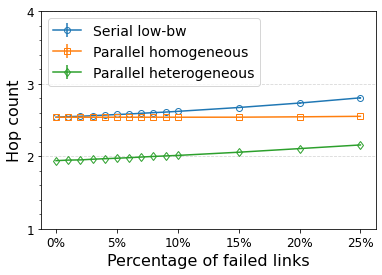

In [6]:
experiments = [ 'single', 'homogeneous', 'heterogeneous']

plot_percentage = False

MARKER_INDEX = {
    'single': 1,
    'large': 1,
    'homogeneous': 2,
    'heterogeneous': 3,
}

COLORS = {
    'single': '#1f77b4',
    'homogeneous': '#ff7f0e',
    'heterogeneous': '#2ca02c',
    'large': '#d62728',
}

index = 0
for exp in experiments:
    exp_dir = os.path.join(ROOT_DIR, exp)
    flow_path_stats_filename = os.path.join(exp_dir, "flow-paths.stats.txt")
    path_length_by_fail_rate = parse_flow_path_stats_file(flow_path_stats_filename)
    values_x = []
    values_y = []
    values_err = []
    for fail_rate in sorted(path_length_by_fail_rate):
        if fail_rate > 0.25:
            break
        path_length_array = path_length_by_fail_rate[fail_rate]
        values_x.append(fail_rate)
        values_y.append(np.average(path_length_array))
        values_err.append(np.std(path_length_array))
    if plot_percentage:
        base_y = values_y[0]
        values_y = (np.array(values_y) / base_y - 1) * 100
        values_err = np.array(values_err) / base_y
    values_x = np.array(values_x) * 100 # to percent
    exp_name = get_exp_name(exp)
    plot_errorbar(values_x, values_y, values_err, exp_name, color=COLORS[exp], marker=get_marker(MARKER_INDEX[exp]), fillstyle='none')
    index += 1
plt.legend(fontsize=14, loc='upper left')
plt.xlabel('Percentage of failed links', fontsize=16)
if plot_percentage:
    plt.ylim(0, 24)
    plt.ylabel('Percentage increase of path length', fontsize=16)
else:
    plt.ylim(1, 4)
    plt.ylabel('Hop count', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.grid(True, alpha=0.5, linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.yaxis.grid(True, alpha=0.5, which='minor', linestyle='--')
if save_figures:
    plt.savefig('fault-tolerance.hop_count-vs-fail_rate.png')